In [9]:
# Various torch packages
import torch
import torch.nn as nn
import torch.nn.functional as F

# torchvision
from torchvision import datasets, transforms

# ------------------------
# get up one directory 
import sys, os
sys.path.append(os.path.abspath('../'))
# ------------------------

# custom packages
import matplotlib.pyplot as plt
import models.aux_funs as maf
import optimizers as op
import regularizers as reg
import train
import math
import utils.configuration as cf
import utils.datasets as ud
import pandas as pd
from models.mnist_conv import mnist_conv
from models.aux_funs import net_sparsity

# Fix the random seed

In [2]:
random_seed = 2
cf.seed_torch(random_seed)

# Configure the expirement

In [11]:
weights_path = '../checkpoints/mnist_conv_sparse_linbreg_ggmodel.pth'

conf_args = {#
    # data specification
    'data_file':"../../Data",'train_split':0.95, 'data_set':"Fashion-MNIST", 'download':True,
    # cuda
    'use_cuda':False, 'num_workers':0, 'cuda_device':0, 'pin_memory':True,
    #
    'epochs':100,
    # optimizer
    'delta':1.0, 'lr':0.07, 'lamda_0':0.4, 'lamda_1':0.4, 'optim':"AdaBreg", 'conv_group':True,
    'beta':0.0,
    # initialization
    'sparse_init':0.01, 'r':[1,1,1],
    # misc
    'random_seed':random_seed, 'eval_acc':True,
    'batch_size': 1000
}

conf = cf.Conf(**conf_args)

# Initiate model

In [12]:
model_kwargs = {'mean':conf.data_set_mean, 'std':conf.data_set_std}    

model = mnist_conv(**model_kwargs).to(conf.device)

# Load model weights

In [13]:
model_weights = torch.load(weights_path, map_location=conf.device)

# Apply the weights
model.load_state_dict(model_weights)

model

mnist_conv(
  (act_fn): ReLU()
  (layers1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (layers2): Sequential(
    (0): Linear(in_features=1024, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)

# Dataset

In [14]:
train_loader, valid_loader, test_loader = ud.get_data_set(conf)

# Show the model works

In [15]:
train.test(conf, model, test_loader)

--------------------------------------------------
Test Accuracy: 0.8513


{'acc': 0.8513, 'loss': 4.152145177125931}

In [16]:
net_sparsity(model)


0.016788518819388032

In [19]:

sparsities = [0.01, 0.05, 0.1, 0.2, 0.5, 1]
for sparsity in sparsities:
    weights_path = f'../checkpoints/adabreg/mnist_conv_{sparsity}.pth'
    model_weights = torch.load(weights_path, map_location=conf.device)

    # Apply the weights
    model.eval()
    model.load_state_dict(model_weights)
    nsparsity = net_sparsity(model)

    print(f'Init sparsity: {sparsity} - Network sparsity: {nsparsity}')
    train.test(conf, model, test_loader)

Sparsity: 0.01 - Number of parameters: 87459 / 236618 = 36.96
--------------------------------------------------
Test Accuracy: 0.1
Sparsity: 0.05 - Number of parameters: 97553 / 236618 = 41.23
--------------------------------------------------
Test Accuracy: 0.8099
Sparsity: 0.1 - Number of parameters: 101656 / 236618 = 42.96
--------------------------------------------------
Test Accuracy: 0.8144
Sparsity: 0.2 - Number of parameters: 110591 / 236618 = 46.74
--------------------------------------------------
Test Accuracy: 0.8046
Sparsity: 0.5 - Number of parameters: 121543 / 236618 = 51.37
--------------------------------------------------
Test Accuracy: 0.7764
Sparsity: 1 - Number of parameters: 147785 / 236618 = 62.46
--------------------------------------------------
Test Accuracy: 0.7988


# Attack the Model

In [17]:
def bim_attack(model, data, target, eps, alpha, iters):
    # Copy the original images to avoid modifying them
    adv_images = data.clone().detach().requires_grad_(True)
    
    # Loop over the number of iterations
    for i in range(iters):
        # Requires gradient

        # Forward pass
        outputs = model(adv_images)

        model.zero_grad()

        # Calculate loss
        loss = F.cross_entropy(outputs, target)

        # Backward pass
        loss.backward()
        
        # Adversarial example update
        with torch.no_grad():
            grad = adv_images.grad
            if grad is None:
                print(f'grad is None at {i}')
                continue
                
            perturbation = alpha * grad.sign()
            adv_images = adv_images + perturbation
            perturbation = torch.clamp(adv_images - data, min=-eps, max=eps)
            adv_images = torch.clamp(data + perturbation, min=0, max=1)
            adv_images = adv_images.detach().requires_grad_(True)

    return adv_images.detach()

def get_batch(loader):
    for data, target in loader:
        return data, target
    
    
def test_bim(model, data, target, conf, epsilon, alpha):
    correct = 0
    adv_examples = []
    for x, y in zip(data, target):
        x, y = x.unsqueeze(0).to(conf.device), y.to(conf.device)
        output = model(x)
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == y.item():
            correct += 1
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = x.squeeze().detach().cpu().numpy()
                adv_examples.append( (y.item(), final_pred.item(), adv_ex) )
        
    final_acc = correct/float(len(test_loader))
    print(f"Epsilon: {epsilon}\tTest Accuracy = {correct} / {len(data)} = {final_acc}")

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [26]:
x, y = get_batch(test_loader)
model.train()
output = model(x)
loss = F.cross_entropy(output, y)
model.zero_grad()
loss.backward()

/var/folders/dh/qbjs69w13zj6ryqn2r6jy0lh0000gn/T/ipykernel_26885/2815831335.py:9: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  output.grad


In [134]:
alpha = .1
iters = 10
epsilons = [0, .005, .05, .1, .15, .2, .25, .3]
accuracies = []
examples = []

data, target = get_batch(test_loader)

for eps in epsilons:

    adv_examples = bim_attack(model, data, target, eps, alpha, iters)
    acc, ex = test_bim(model, adv_examples, target, conf, eps, alpha)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 907 / 1000 = 90.7
Epsilon: 0.005	Test Accuracy = 857 / 1000 = 85.7
Epsilon: 0.05	Test Accuracy = 362 / 1000 = 36.2
Epsilon: 0.1	Test Accuracy = 46 / 1000 = 4.6
Epsilon: 0.15	Test Accuracy = 1 / 1000 = 0.1
Epsilon: 0.2	Test Accuracy = 0 / 1000 = 0.0
Epsilon: 0.25	Test Accuracy = 0 / 1000 = 0.0
Epsilon: 0.3	Test Accuracy = 0 / 1000 = 0.0


In [135]:
data_dict = { 'epsilons': epsilons, 'accuracy': accuracies }
df = pd.DataFrame(data_dict)
df

,epsilons,accuracy
0,0.000,90.7
1,0.005,85.7
2,0.050,36.2
3,0.100,4.6
4,0.150,0.1
5,0.200,0.0
6,0.250,0.0
7,0.300,0.0


In [136]:
df.to_csv('../results/dense_adam_BIM_attack.csv')

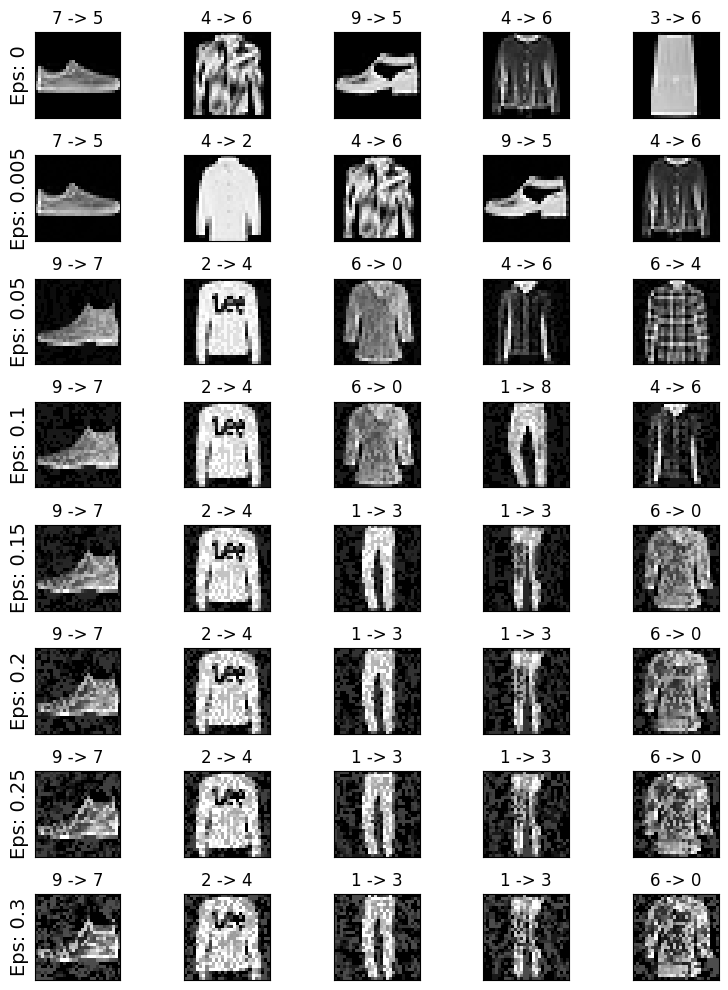

In [137]:
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(f"Eps: {epsilons[i]}", fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title(f"{orig} -> {adv}")
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()    